# 使用 Vision Transformers 与 CNN 进行 MNIST 分类实验

## 导包与设置

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split

import os
import wandb
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark     = False

## 数据集

In [2]:
mnist_train = datasets.MNIST(root='data', train=True,  transform=transforms.ToTensor(), download=True)
mnist_test  = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

<hr>

## CNN on MNIST

### 数据载入

In [4]:
class MNISTDataLoaders():
    def __init__(self, batch_size=64, train_subset_size=None):
        self.transform    = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

        self.train_data   = datasets.MNIST(root='data', train=True,  transform=self.transform, download=True)
        self.test_data    = datasets.MNIST(root='data', train=False, transform=self.transform, download=True)

        if train_subset_size is None or train_subset_size == len(self.train_data):
            self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)

        else:
            data_indices      = np.arange(len(self.train_data))
            train_indices, _  = train_test_split(data_indices, train_size=train_subset_size, stratify=self.train_data.targets.numpy())

            self.train_data   = torch.utils.data.Subset(self.train_data, train_indices)
            self.train_loader = torch.utils.data.DataLoader(self.train_data, batch_size=batch_size, shuffle=True)

        self.test_loader  = torch.utils.data.DataLoader(self.test_data,  batch_size=batch_size, shuffle=False)

### 网络结构

In [5]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.conv1   = nn.Conv2d(in_channels=1, out_channels=6,  kernel_size=5)
        self.conv2   = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)

        self.fc1     = nn.Linear(in_features=16*4*4, out_features=120)
        self.fc2     = nn.Linear(in_features=120,    out_features=84)
        self.fc3     = nn.Linear(in_features=84,     out_features=10)

        self.pool    = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 1, 28, 28)

        x = self.conv1(x) # x -> 24x24x6
        x = self.pool(x)  # x -> 12x12x6
        x = self.relu(x)

        x = self.conv2(x) # x -> 8x8x16
        x = self.pool(x)  # x -> 4x4x16
        x = self.relu(x)

        x = x.view(-1, 16*4*4) # x -> 256

        x = self.fc1(x) # x -> 120
        x = self.relu(x)

        x = self.fc2(x) # x -> 84
        x = self.relu(x)

        x = self.fc3(x) # x -> 10
        x = self.softmax(x)

        return x

### 训练与测试

In [6]:
class Trainer():
    def __init__(self, model, train_loader, test_loader, optimizer, criterion=nn.CrossEntropyLoss(), logging=False):
        self.model        = model
        self.train_loader = train_loader
        self.test_loader  = test_loader
        self.optimizer    = optimizer
        self.criterion    = criterion
        self.logging      = logging

    def train_epoch(self, epochs=10, log_interval=100):
        for epoch in range(epochs):
            self.model.train()

            train_loss = 0.0
            train_acc  = 0.0

            train_progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader))
            for batch_idx, (data, target) in train_progress_bar:
                self.optimizer.zero_grad()

                output = self.model(data)

                batch_loss  = self.criterion(output, target)
                train_loss += batch_loss.mean().item()
                batch_loss.backward()

                pred         = output.argmax(dim=1)
                train_acc  += (pred == target).sum().item() / len(target)

                self.optimizer.step()

                train_progress_bar.set_description(f'Epoch {epoch+1}/{epochs}: Train epoch')
                train_progress_bar.set_postfix(Loss=train_loss/(batch_idx+1), Accuracy=train_acc/(batch_idx+1))

                if self.logging and ((batch_idx+1) % log_interval == 0 or (batch_idx+1) == len(self.train_loader)):
                    wandb.log({'Train Loss': train_loss/(batch_idx+1), 'Train Accuracy': train_acc/(batch_idx+1)})

            self.test_epoch(epoch, epochs)

            print()

        return train_acc / len(self.train_loader), train_loss / len(self.train_loader)

    def test_epoch(self, epoch=None, epochs=None, log_interval=25):
        self.model.eval()

        test_loss = 0
        test_acc  = 0

        with torch.no_grad():
            test_progress_bar = tqdm(enumerate(self.test_loader), total=len(self.test_loader))
            for batch_idx, (data, target) in test_progress_bar:
                output = self.model(data)

                test_loss += self.criterion(output, target).mean().item()

                pred       = output.argmax(dim=1)
                test_acc  += (pred == target).sum().item() / len(target)

                if epoch is not None and epochs is not None:
                    test_progress_bar.set_description(f'Epoch {epoch+1}/{epochs}: Test epoch ')
                    test_progress_bar.set_postfix(Loss=test_loss/(batch_idx+1), Accuracy=test_acc/(batch_idx+1))
                else:
                    test_progress_bar.set_postfix(Loss=test_loss/(batch_idx+1), Accuracy=test_acc/(batch_idx+1))

                if self.logging and ((batch_idx+1) % log_interval == 0 or (batch_idx+1) == len(self.test_loader)):
                    wandb.log({'Test Loss': test_loss/(batch_idx+1), 'Test Accuracy': test_acc/(batch_idx+1)})

        return test_acc / len(self.test_loader), test_loss / len(self.test_loader)

    def predict(self, data):
        self.model.eval()

        with torch.no_grad():
            output = self.model(data)
            pred   = output.argmax(dim=1)

        return pred

In [14]:
data_loaders = MNISTDataLoaders()
train_loader = data_loaders.train_loader
test_loader  = data_loaders.test_loader

model        = LeNet()

optimizer    = optim.Adam(model.parameters(), lr=0.001)

trainer      = Trainer(model, train_loader, test_loader, optimizer)

trainer.train_epoch(epochs=5)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 55.48it/s, Accuracy=0.966, Loss=1.5] 


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 47.10it/s, Accuracy=0.976, Loss=1.48]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 55.21it/s, Accuracy=0.979, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 53.56it/s, Accuracy=0.98, Loss=1.48] 


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 57.35it/s, Accuracy=0.983, Loss=1.48]

(0.9818263592750534, 1.4796368341201913)

<hr>

## 超参数调优：batch size, learning rate, optimizer

In [15]:
configs = [
    {'batch_size': 64, 'lr': 0.001,  'optimizer': 'Adam'},
    {'batch_size': 32, 'lr': 0.001,  'optimizer': 'Adam'},
    {'batch_size': 64, 'lr': 0.0001, 'optimizer': 'Adam'},
    {'batch_size': 64, 'lr': 0.001,  'optimizer': 'SGD'},
    {'batch_size': 32, 'lr': 0.001,  'optimizer': 'SGD'},
    {'batch_size': 64, 'lr': 0.0001, 'optimizer': 'SGD'}
]

max_accuracy = 0
accuracies   = []
best_config  = None

os.environ["WANDB_SILENT"] = "true"
wandb.login()

for config in configs:
    wandb.init(
        project = 'MNIST-Classification',
        config  = config,
        notes   = 'LeNet-Tuning'
    )

    data_loaders = MNISTDataLoaders(batch_size=config['batch_size'])
    train_loader = data_loaders.train_loader
    test_loader  = data_loaders.test_loader

    model = LeNet()

    if config['optimizer'] == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=config['lr'])
    else:
        optimizer = optim.SGD(model.parameters(), lr=config['lr'])

    trainer = Trainer(model, train_loader, test_loader, optimizer, logging=True)

    print(f"Training model with batch_size={config['batch_size']}, lr={config['lr']} and {config['optimizer']} optimizer...")
    trainer.train_epoch(epochs=5)

    print("Evaluation on test set...")
    accuracy, _ = trainer.test_epoch()

    accuracies.append(accuracy)

    if accuracy > max_accuracy:
        max_accuracy = accuracy
        best_config  = config

    print("====================================================")
    print()

    wandb.finish()

Training model with batch_size=64, lr=0.001 and Adam optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.94it/s, Accuracy=0.879, Loss=1.58]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 50.54it/s, Accuracy=0.973, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 50.90it/s, Accuracy=0.977, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.19it/s, Accuracy=0.98, Loss=1.48] 


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 52.28it/s, Accuracy=0.984, Loss=1.48]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 58.47it/s, Accuracy=0.984, Loss=1.48]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training model with batch_size=32, lr=0.001 and Adam optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 78.49it/s, Accuracy=0.972, Loss=1.49]


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 79.58it/s, Accuracy=0.969, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 80.20it/s, Accuracy=0.98, Loss=1.48] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 82.07it/s, Accuracy=0.981, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 78.56it/s, Accuracy=0.985, Loss=1.48]



Evaluation on test set...


100%|██████████| 313/313 [00:03<00:00, 80.82it/s, Accuracy=0.985, Loss=1.48] 


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training model with batch_size=64, lr=0.0001 and Adam optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 52.57it/s, Accuracy=0.751, Loss=1.72]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 53.73it/s, Accuracy=0.77, Loss=1.69] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 52.10it/s, Accuracy=0.777, Loss=1.68]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 50.72it/s, Accuracy=0.779, Loss=1.68]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.70it/s, Accuracy=0.782, Loss=1.68]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 57.50it/s, Accuracy=0.782, Loss=1.68]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training model with batch_size=64, lr=0.001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 52.07it/s, Accuracy=0.119, Loss=2.3]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 50.94it/s, Accuracy=0.14, Loss=2.3] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.42it/s, Accuracy=0.161, Loss=2.3]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.94it/s, Accuracy=0.179, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 50.63it/s, Accuracy=0.187, Loss=2.3]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 57.51it/s, Accuracy=0.187, Loss=2.3]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training model with batch_size=32, lr=0.001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:04<00:00, 73.72it/s, Accuracy=0.103, Loss=2.3] 


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:04<00:00, 72.36it/s, Accuracy=0.105, Loss=2.3] 


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 80.00it/s, Accuracy=0.111, Loss=2.3] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 81.62it/s, Accuracy=0.124, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 85.30it/s, Accuracy=0.146, Loss=2.3]



Evaluation on test set...


100%|██████████| 313/313 [00:03<00:00, 97.30it/s, Accuracy=0.146, Loss=2.3] 


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


Training model with batch_size=64, lr=0.0001 and SGD optimizer...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 53.01it/s, Accuracy=0.1, Loss=2.3]   


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 48.80it/s, Accuracy=0.101, Loss=2.3]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 52.55it/s, Accuracy=0.101, Loss=2.3]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 55.81it/s, Accuracy=0.101, Loss=2.3]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 51.43it/s, Accuracy=0.101, Loss=2.3]



Evaluation on test set...


100%|██████████| 157/157 [00:02<00:00, 58.91it/s, Accuracy=0.101, Loss=2.3]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


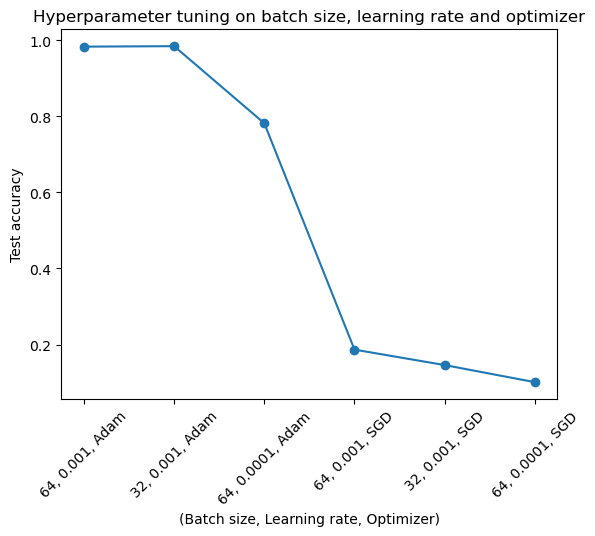

In [16]:
plt.plot([f'{config["batch_size"]}, {config["lr"]}, {config["optimizer"]}' for config in configs], accuracies, marker='o')
plt.xticks([f'{config["batch_size"]}, {config["lr"]}, {config["optimizer"]}' for config in configs], rotation=45)
plt.xlabel('(Batch size, Learning rate, Optimizer)')
plt.ylabel('Test accuracy')
plt.title('Hyperparameter tuning on batch size, learning rate and optimizer')
plt.show()

## 实验结果分析
- Adam优化器在准确率方面明显优于SGD优化器
- 相较于1e-3的较高学习率，1e-4的较低学习率收敛速度更慢且性能更差
- 批量大小对模型性能没有显著影响

- 综上，对于以上六个参数组合，LeNet模型的最佳配置为：
    - Optimizer = Adam
    - Learning rate = 1e-3
    - Batch size = 32

<hr>

## 网络结构调整

In [ ]:
class DoubleLeNet(nn.Module):
    def __init__(self):
        super(DoubleLeNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1,  out_channels=6,  kernel_size=5, padding=2)
        self.conv2 = nn.Conv2d(in_channels=6,  out_channels=16, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=2)
        self.conv4 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=2)

        self.fc1   = nn.Linear(in_features=64*3*3, out_features=120)
        self.fc2   = nn.Linear(in_features=120,    out_features=84)
        self.fc3   = nn.Linear(in_features=84,     out_features=10)

        self.pool  = nn.MaxPool2d(kernel_size=2, stride=2)

        self.relu    = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Pytorch has convention (batch_size, channels, height, width)
        x = x.view(-1, 1, 28, 28)

        x = self.conv1(x) # x -> 28x28x6
        x = self.pool(x)  # x -> 14x14x6
        x = self.relu(x)

        x = self.conv2(x) # x -> 14x14x16
        x = self.pool(x)  # x -> 7x7x16
        x = self.relu(x)

        x = self.conv3(x) # x -> 9x9x32
        x = self.pool(x)  # x -> 4x4x32

        x = self.conv4(x) # x -> 6x6x64
        x = self.pool(x)  # x -> 3x3x64
        x = self.relu(x)

        x = x.view(-1, 64*3*3) # x -> 576 (Flattened to pass through fully connected layers)

        x = self.fc1(x) # x -> 120
        x = self.relu(x)

        x = self.fc2(x) # x -> 84
        x = self.relu(x)

        x = self.fc3(x) # x -> 10
        x = self.softmax(x) # For probabilities

        return x
    
double_data_loaders = MNISTDataLoaders()
double_train_loader = double_data_loaders.train_loader
double_test_loader  = double_data_loaders.test_loader

double_model        = DoubleLeNet()

double_optimizer    = optim.Adam(double_model.parameters(), lr=0.001)

double_trainer      = Trainer(double_model, double_train_loader, double_test_loader, double_optimizer)

double_trainer.train_epoch(epochs=5)

Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 42.09it/s, Accuracy=0.954, Loss=1.51]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 45.03it/s, Accuracy=0.968, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 42.13it/s, Accuracy=0.955, Loss=1.51]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 46.51it/s, Accuracy=0.981, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:03<00:00, 44.98it/s, Accuracy=0.976, Loss=1.49]

## 实验结果分析
- LeNet卷积层的数量翻倍，但性能没有太大变化
-  需要对结构进行更改： kernel size 和 padding ，确保特征映射在到达最后一层时足够大

- 数据中存在的关系可以通过正常的LeNet模型来学习，但网络结构更高的复杂性无助于提供额外的信息
- 调整后与正常的LeNet模型相比性能略低，可能存在过拟合

<hr>

## 准确率与训练样本数量

In [ ]:
train_dataset_sizes = [600, 1800, 6000, 18000, 60000]
accuracies          = []

for train_dataset_size in train_dataset_sizes:
    print(f"Training with {train_dataset_size} samples...")

    batch_size   = 32 if train_dataset_size < 10000 else 64
    data_loaders = MNISTDataLoaders(batch_size=batch_size, train_subset_size=train_dataset_size)
    train_loader = data_loaders.train_loader
    test_loader  = data_loaders.test_loader

    model        = LeNet()

    optimizer    = optim.Adam(model.parameters(), lr=0.001)

    trainer      = Trainer(model, train_loader, test_loader, optimizer)

    trainer.train_epoch(epochs=5)

    print("Evaluating the model on test set...")
    test_acc, _ = trainer.test_epoch()
    accuracies.append(test_acc)

    print("====================================================")
    print()

Training with 600 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 57.65it/s, Accuracy=0.153, Loss=2.29]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.34it/s, Accuracy=0.327, Loss=2.22]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 57.52it/s, Accuracy=0.382, Loss=2.1] 


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.66it/s, Accuracy=0.614, Loss=1.94]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.08it/s, Accuracy=0.724, Loss=1.81]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 64.15it/s, Accuracy=0.724, Loss=1.81]



Training with 1800 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.49it/s, Accuracy=0.411, Loss=2.09]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.11it/s, Accuracy=0.769, Loss=1.72]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.26it/s, Accuracy=0.855, Loss=1.62]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.66it/s, Accuracy=0.894, Loss=1.58]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.79it/s, Accuracy=0.905, Loss=1.57]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 62.85it/s, Accuracy=0.905, Loss=1.57]



Training with 6000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 55.91it/s, Accuracy=0.788, Loss=1.68]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.56it/s, Accuracy=0.83, Loss=1.63] 


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 57.27it/s, Accuracy=0.852, Loss=1.61]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.91it/s, Accuracy=0.844, Loss=1.62]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.71it/s, Accuracy=0.867, Loss=1.59]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 63.08it/s, Accuracy=0.867, Loss=1.59]



Training with 18000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.60it/s, Accuracy=0.853, Loss=1.61]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.28it/s, Accuracy=0.958, Loss=1.51]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 56.74it/s, Accuracy=0.962, Loss=1.5] 


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 54.82it/s, Accuracy=0.971, Loss=1.49]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 54.82it/s, Accuracy=0.974, Loss=1.49]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 62.22it/s, Accuracy=0.974, Loss=1.49]



Training with 60000 samples...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.93it/s, Accuracy=0.958, Loss=1.51]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.40it/s, Accuracy=0.973, Loss=1.49]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 63.95it/s, Accuracy=0.968, Loss=1.49]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 62.58it/s, Accuracy=0.983, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.33it/s, Accuracy=0.982, Loss=1.48]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 64.59it/s, Accuracy=0.982, Loss=1.48]

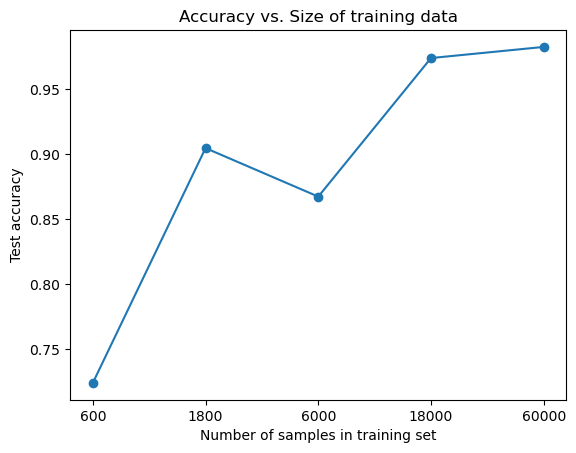

In [ ]:
plt.plot([str(size) for size in train_dataset_sizes], accuracies, marker='o')
plt.xlabel('Number of samples in training set')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs. Size of training data')
plt.show()

## 实验结果分析
- 训练样本很少时，准确性非常低
- 训练数据量只略有增加，准确率就会大幅提高
- 这可以解释为，由于数据在所有标签上的均匀分布，数据的增加足够让CNN捕获数据中所有需要的模式
- 在一个点后添加更多数据对模型没有多大好处——考虑从18K图像到60K图像的跳跃
- 三分之一的数据性能相似

<hr>

## TransformerEncoder on MNIST

In [ ]:
class VITTransformerEncoder(nn.Module):
    def __init__(self, patch_size=7, embed_dim=64, num_layers=2, num_heads=4, num_classes=10):
        super(VITTransformerEncoder, self).__init__()
        self.patch_size = patch_size
        self.embed_dim  = embed_dim

        self.patch_embedding = nn.Conv2d(in_channels=1, out_channels=embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token       = nn.Parameter(torch.randn(1, 1, embed_dim)) 
        self.pos_embedding   = nn.Parameter(torch.randn(1, (28 // patch_size) ** 2 + 1, embed_dim))

        self.transformer     = nn.TransformerEncoder(encoder_layer=nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, batch_first=True), num_layers=num_layers)
        self.cls_head        = nn.Linear(embed_dim, num_classes)
        self.softmax         = nn.Softmax(dim=1)

    def forward(self, x):
        b, _, _, _ = x.shape

        # 按照Torch的(b x c x h x w)格式，通过沿最后一个维度展开来线性化嵌入
        # 然后转置为b x hw x c格式
        x = self.patch_embedding(x).flatten(2).transpose(1, 2)

        # 在每个补丁嵌入的开头加类标记
        cls_token = self.cls_token.repeat(b, 1, 1)
        x         = torch.cat([cls_token, x], dim=1)

        # 位置嵌入
        x += self.pos_embedding
        x  = self.transformer(x)

        # 类嵌入出现在补丁嵌入的开头 -(b x n x(1+c))
        cls_encoding = x[:, 0, :]
        cls_encoding = self.cls_head(cls_encoding)
        cls_encoding = self.softmax(cls_encoding)
        return cls_encoding

In [ ]:
train_dataset_sizes = [6000, 60000]
LeNet_accuracies    = []
VIT_accuracies      = []

for train_dataset_size in train_dataset_sizes:
    print(f"Training with {train_dataset_size} samples...")
    print()

    batch_size   = 32 if train_dataset_size < 10000 else 64
    data_loaders = MNISTDataLoaders(batch_size=batch_size, train_subset_size=train_dataset_size)
    train_loader = data_loaders.train_loader
    test_loader  = data_loaders.test_loader

    LeNet_model  = LeNet()
    VIT_model    = VITTransformerEncoder()

    LeNet_optimizer = optim.Adam(LeNet_model.parameters(), lr=0.001)
    VIT_optimizer   = optim.Adam(VIT_model.parameters(),   lr=0.001)

    LeNet_trainer = Trainer(LeNet_model, train_loader, test_loader, LeNet_optimizer)
    VIT_trainer   = Trainer(VIT_model,   train_loader, test_loader, VIT_optimizer)

    print("Training LeNet...")
    LeNet_trainer.train_epoch(epochs=5)
    print("Evaluating the model on test set...")
    LeNet_test_acc, _ = LeNet_trainer.test_epoch()
    print()

    print("Training VIT...")
    VIT_trainer.train_epoch(epochs=5)
    print("Evaluating the model on test set...")
    VIT_test_acc, _ = VIT_trainer.test_epoch()

    LeNet_accuracies.append(LeNet_test_acc)
    VIT_accuracies.append(VIT_test_acc)

    print("====================================================")
    print()

Training with 6000 samples...

Training LeNet...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 98.95it/s, Accuracy=0.824, Loss=1.65] 


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 97.99it/s, Accuracy=0.849, Loss=1.62] 


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 96.26it/s, Accuracy=0.922, Loss=1.54] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 97.07it/s, Accuracy=0.949, Loss=1.52] 


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:03<00:00, 99.01it/s, Accuracy=0.961, Loss=1.5]  



Evaluating the model on test set...


100%|██████████| 313/313 [00:02<00:00, 114.28it/s, Accuracy=0.961, Loss=1.5] 



Training VIT...


Epoch 1/5: Test epoch : 100%|██████████| 313/313 [00:06<00:00, 52.14it/s, Accuracy=0.768, Loss=1.71]


Epoch 2/5: Test epoch : 100%|██████████| 313/313 [00:05<00:00, 53.90it/s, Accuracy=0.777, Loss=1.69]


Epoch 3/5: Test epoch : 100%|██████████| 313/313 [00:05<00:00, 54.06it/s, Accuracy=0.863, Loss=1.6] 


Epoch 4/5: Test epoch : 100%|██████████| 313/313 [00:05<00:00, 54.84it/s, Accuracy=0.87, Loss=1.59] 


Epoch 5/5: Test epoch : 100%|██████████| 313/313 [00:05<00:00, 54.07it/s, Accuracy=0.894, Loss=1.57]



Evaluating the model on test set...


100%|██████████| 313/313 [00:05<00:00, 55.56it/s, Accuracy=0.894, Loss=1.57]



Training with 60000 samples...

Training LeNet...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 59.59it/s, Accuracy=0.874, Loss=1.59]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 61.80it/s, Accuracy=0.977, Loss=1.48]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 58.20it/s, Accuracy=0.977, Loss=1.48]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.18it/s, Accuracy=0.981, Loss=1.48]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:02<00:00, 60.43it/s, Accuracy=0.979, Loss=1.48]



Evaluating the model on test set...


100%|██████████| 157/157 [00:02<00:00, 65.23it/s, Accuracy=0.979, Loss=1.48]



Training VIT...


Epoch 1/5: Test epoch : 100%|██████████| 157/157 [00:05<00:00, 27.46it/s, Accuracy=0.933, Loss=1.53]


Epoch 2/5: Test epoch : 100%|██████████| 157/157 [00:05<00:00, 26.26it/s, Accuracy=0.941, Loss=1.52]


Epoch 3/5: Test epoch : 100%|██████████| 157/157 [00:05<00:00, 29.03it/s, Accuracy=0.946, Loss=1.51]


Epoch 4/5: Test epoch : 100%|██████████| 157/157 [00:05<00:00, 28.78it/s, Accuracy=0.947, Loss=1.51]


Epoch 5/5: Test epoch : 100%|██████████| 157/157 [00:05<00:00, 28.30it/s, Accuracy=0.949, Loss=1.51]



Evaluating the model on test set...


100%|██████████| 157/157 [00:05<00:00, 29.80it/s, Accuracy=0.949, Loss=1.51]

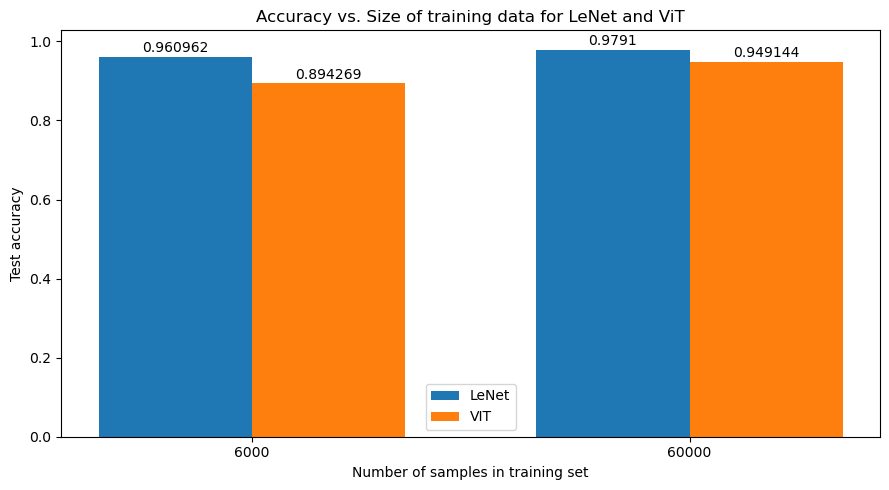

In [ ]:
indices   = np.arange(len(train_dataset_sizes))
bar_width = 0.35
plt.figure(figsize=(9, 5))

lenet_bars = plt.bar(indices,             LeNet_accuracies, bar_width, label='LeNet')
vit_bars   = plt.bar(indices + bar_width, VIT_accuracies,   bar_width, label='VIT')

plt.bar_label(lenet_bars, padding=1)
plt.bar_label(vit_bars,   padding=1)

plt.xlabel('Number of samples in training set')
plt.ylabel('Test accuracy')
plt.title('Accuracy vs. Size of training data for LeNet and ViT')
plt.xticks(indices + bar_width / 2, [str(size) for size in train_dataset_sizes])
plt.legend()
plt.tight_layout()
plt.show()

## 实验结果分析
- CNN 对于较少的训练数据更有效，VIT 对于较多数据更有效
- 这表明attention 和 transformer 结构对训练数据量的需求很大
- 这可以解释为：CNN注重数据样本中的局部空间关系，而注意力机制需要查看整个数据样本，并计算样本中每个标记之间的注意力得分


<hr>